Joint Shapley value calculations on the Boston housing dataset (Harrison and Rubinfeld, 1978, JEEM)

In [1]:
#import xgboost
import shap
import sklearn
import numpy as np
import pandas as pd
import random
import scipy
from IPython.display import display, clear_output

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
sns.set_theme(style="whitegrid")

EMPTY = frozenset()

# from joint_shapley import * # Where most of the JS code is 

In [2]:
k = 1
num_sampling_iterations = 5

In [3]:
def get_powerset_to_k(
    features, 
    k,
    init=True,
):
    if init:
        features = [s if type(s) == frozenset else frozenset([s]) for s in features]
    if len(features) <= 1:
        yield features[0]
        yield frozenset()
    else:
        for item in get_powerset_to_k(features[1:], k, False):
            if len(item) <= k - 1:
                yield features[0].union(item)
            yield item
            
def get_powerset_to_k_ex_emptyset(seq, k):
    gen = get_powerset_to_k(seq, k)
    for item in gen:
        if item != frozenset():
            yield item

In [4]:
dataset_pathname = "boston"
X,y = shap.datasets.boston()
col_rename = {l: f"{l}" for l in X.columns}
X = X.rename(columns=col_rename)
y = y
x_labels = [f"{l}" for l in X.columns]
num_features = len(x_labels)
print(f"Dataset has {num_features} features and {len(y)} observations")

Dataset has 13 features and 506 observations


In [5]:
# Split train/test
np.random.seed(0)
test_train_split = np.random.uniform(0, 1, len(y)) <= .75
train_X = X[test_train_split]
train_y = y[test_train_split]
test_X = X[~test_train_split]
test_y = y[~test_train_split]

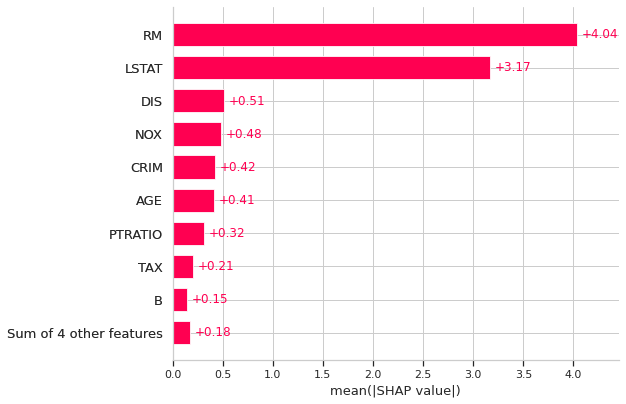

In [6]:
model = sklearn.ensemble.RandomForestRegressor(
    n_jobs=10, n_estimators=50,random_state=0
).fit(train_X, train_y)

y_predicted = model.predict(test_X)
explainer = shap.Explainer(model)
shap_values = explainer(test_X)
shap.plots.bar(shap_values)

In [7]:
n_features = frozenset(x_labels)

#### Define value function

In [8]:
coalitions_to_k = get_powerset_to_k(n_features, k)

baseline = explainer(test_X).base_values

def value_function(cln_X):
#     full_X = test_X.copy()
#     full_X.loc[:, [col not in cln_X.columns for col in X.columns]] = \
#         full_X.mean(axis=0).loc[[col not in cln_X.columns for col in X.columns]].values.T
#     full_X.loc[:, cln_X.columns] = cln_X
    return model.predict(cln_X)# - baseline[0]

In [9]:
def choose(n, k):
    return scipy.special.comb(n, k)

In [10]:
def get_q_values_for_k(k, num_local_features):
    q = np.zeros(num_local_features, dtype=np.longdouble) 
    q0den = sum([
        choose(num_local_features, s) for s in range(1, k+1)
    ])
    q[0] = 1/q0den 
    for r in range(1, num_local_features):
        limd = min(k, (num_local_features - r))
        limn = max((r - k), 0)
        qden = sum([
            choose(num_local_features - r, s) for s in range(1, limd+1)
        ])
        qnum = sum([
            choose(r, s) * q[s] for s in range(limn, r)
        ])
        q[r] = qnum / qden
    # Check that the checksum is satisfied
    checksum = sum([
        choose(num_local_features, i) * q[i] 
        for i in range((num_local_features - k), num_local_features)
    ])
    assert(np.isclose(checksum, 1.0))
    return q

_all_q_values = [get_q_values_for_k(_k, num_features) for _k in range(1, k+1)]
q_values = np.vstack(_all_q_values)

In [11]:
def calculate_phi_t(
    observation,
    all_observations,
    value_function,
    coalition_vc,
    q_values,
    num_sampling_iterations,
):
    features_list = list(observation.index)
    num_features = len(features_list)
    coalition_size = len(coalition_vc)
    assert(features_list == list(all_observations.columns))
    p_values = np.zeros((num_features - coalition_size + 1), dtype=np.longdouble)
    for i in range(1, num_features - coalition_size + 2):
        q_value = q_values[k-1, i-1]
        num_ft_choose_len = choose((num_features - coalition_size), (i - 1))
        p_values[i - 1] = num_ft_choose_len * q_value
    hat_p_values = p_values / np.sum(p_values)
    estimates = np.zeros(num_sampling_iterations)

    for itr in range(0, num_sampling_iterations):
        U = np.random.uniform(0, 1, 1)
        X = sum(U > hat_p_values.cumsum())
        S = set()
        for w in range(1, X + 1):
            possible_next = set(range(1, num_features + 1)).difference(
                set(coalition_vc).union(S))
            r = random.sample(possible_next, 1)
            S = S.union(set(r))

        z_num = random.choice(range(0, len(all_observations)))
        z = all_observations.iloc[z_num]
        
        xminusT = np.copy(observation.values)
        xplusT = np.copy(observation.values)
        coalition_int_set = {features_list.index(ft) for ft in coalition_vc} 
        for h in set(range(0, num_features)).difference(S):
            xminusT[h] = z[h]
        for h in set(range(0, num_features)).difference(S.union(coalition_int_set)):
            xplusT[h] = z[h]
        
        estimates[itr] = value_function(xplusT.reshape(1,-1)) - \
            value_function(xminusT.reshape(1,-1))
    return (np.mean(estimates) * np.sum(p_values))


In [12]:
num_observation = 38 # sets the review to be analysed
sample_observation = test_X.iloc[num_observation]
sample_observation

CRIM         0.08447
ZN           0.00000
INDUS        4.05000
CHAS         0.00000
NOX          0.51000
RM           5.85900
AGE         68.70000
DIS          2.70190
RAD          5.00000
TAX        296.00000
PTRATIO     16.60000
B          393.23000
LSTAT        9.64000
Name: 174, dtype: float64

In [14]:
# Test for a given t and x
t_cln = frozenset(["LSTAT"])
results = {}
for iters in range(10, 300, 10):
    clear_output(wait=True)
    display(f"Processing iter = {iters}")
    results_for_iters = []
    for x in range(0, 10):
        this_res = calculate_phi_t(
            sample_observation,
            test_X,
            value_function,
            t_cln,
            q_values,
            iters
        )
        results_for_iters.append(this_res)
    results[iters] = np.std(results_for_iters)

'Processing iter = 290'

<AxesSubplot:>

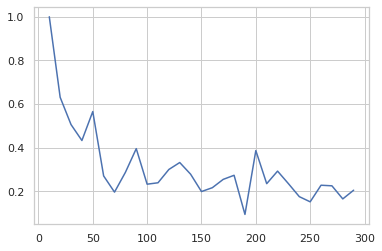

In [15]:
sns.lineplot(x=list(results.keys()), y=list(results.values()))

In [16]:
def reduce_to_most_meaningful(local_js, to=15):
    global_js = local_js.abs().mean(axis=0)
    global_js = global_js.sort_values(ascending=False)
    most_meaningful_coalitions = global_js.iloc[:to]
    return most_meaningful_coalitions.index

### Run calculation using new process

In [17]:
coalitions_to_k_ex_empty = list(get_powerset_to_k(n_features, k))
coalitions_to_k_ex_empty.remove(frozenset())

local_js = pd.DataFrame()

for n, observation in enumerate(test_X.iloc):
    clear_output(wait=True)
    display(f"Processing observation = {n} / {len(test_X)}")
    for coalition in coalitions_to_k_ex_empty:
        local_js.loc[n, coalition] = calculate_phi_t(
            observation,
            test_X,
            value_function,
            coalition,
            q_values,
            num_sampling_iterations
        )
        # print(f'k = {k}, review {n}, coalition {coalition}: local jShapley = {js}')
    


'Processing observation = 120 / 121'

In [19]:
global_js = np.abs(local_js).mean(axis=0)

In [21]:
# export all local, global joint Shapleys
local_js.to_csv(f"local_{dataset_pathname}_all_js_k_{k}.csv")
global_js.to_csv(f"global_{dataset_pathname}_all_js_k_{k}.csv")

In [22]:
new_mm_local_js = local_js.loc[:, reduce_to_most_meaningful(local_js)]
new_mm_global_js = global_js.loc[reduce_to_most_meaningful(local_js)]

In [23]:
def show_strip_plot(local_js):
    stacked = local_js.stack().to_frame().rename(columns={0: "Joint Shapley"})
    stacked.loc[:, "Coalition"] = [ind[1] for ind in stacked.index]
    f, ax = plt.subplots()
    sns.despine(bottom=True, left=True)
    ax = sns.stripplot(
        x="Joint Shapley",
        y="Coalition",
        data=stacked, 
        dodge=True, alpha=.5, zorder=1)
    ax.xaxis.label.set_size(10)#set_xlabel("Coalition", fontsize=6)
    plt.show()

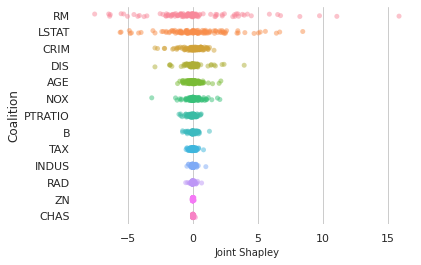

In [24]:
show_strip_plot(new_mm_local_js)

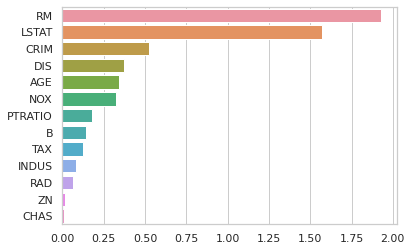

In [25]:
f, ax = plt.subplots()
sns.lineplot(bottom=True, left=True)
_ = sns.barplot(x=new_mm_global_js.values, y=new_mm_global_js.index)

In [26]:
new_mm_local_js.to_csv(f"local_{dataset_pathname}_js_k_{k}.csv")
new_mm_global_js.to_csv(f"globa_{dataset_pathname}_js_k_{k}.csv")